# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

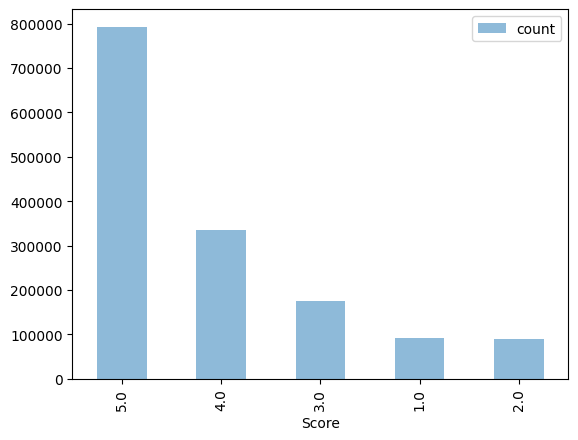


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("/content/drive/My Drive/Midterm/train.csv")
testingSet = pd.read_csv("/content/drive/My Drive/Midterm/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [4]:
def add_features_to(df):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['Summary_Length'] = df['Summary'].str.len().fillna(0)
    return df

# Load the feature extracted files if they've already been generated
if exists('/content/drive/My Drive/Midterm/X_train.csv'):
    X_train = pd.read_csv("/content/drive/My Drive/Midterm/X_train.csv")
if exists('/content/drive/My Drive/Midterm/X_submission.csv'):
    X_submission = pd.read_csv("/content/drive/My Drive/Midterm/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("/content/drive/My Drive/Midterm/X_submission.csv", index=False)
    X_train.to_csv("/content/drive/My Drive/Midterm/X_train.csv", index=False)

# Sample + Split into training and testing set

In [5]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'Summary_Length','Text']
X_train_select = X_train[features].copy()
X_test_select = X_test[features].copy()
X_submission_select = X_submission[features].copy()


X_train_select['Combined_Text'] = X_train['Summary'].fillna('') + ' ' + X_train['Text'].fillna('')
X_test_select['Combined_Text'] = X_test['Summary'].fillna('') + ' ' + X_test['Text'].fillna('')
X_submission_select['Combined_Text'] = X_submission['Summary'].fillna('') + ' ' + X_submission['Text'].fillna('')


X_train_select['Length_Helpfulness'] = X_train_select['Summary_Length'] * X_train_select['Helpfulness']
X_test_select['Length_Helpfulness'] = X_test_select['Summary_Length'] * X_test_select['Helpfulness']
X_submission_select['Length_Helpfulness'] = X_submission_select['Summary_Length'] * X_submission_select['Helpfulness']


vectorizer = TfidfVectorizer(max_features=2**18, stop_words='english', ngram_range=(1,2))


X_train_text = vectorizer.fit_transform(X_train_select['Combined_Text'])
X_test_text = vectorizer.transform(X_test_select['Combined_Text'])
X_submission_text = vectorizer.transform(X_submission_select['Combined_Text'])


X_train_help = csr_matrix(X_train_select[['Helpfulness', 'Length_Helpfulness']].fillna(0).values)
X_test_help = csr_matrix(X_test_select[['Helpfulness', 'Length_Helpfulness']].fillna(0).values)
X_submission_help = csr_matrix(X_submission_select[['Helpfulness', 'Length_Helpfulness']].fillna(0).values)

X_train_combined = hstack([X_train_text, X_train_help])
X_test_combined = hstack([X_test_text, X_test_help])
X_submission_combined = hstack([X_submission_text, X_submission_help])

print(X_train_select.shape[1])



8


# Model Creation

In [45]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-4, n_jobs=-1, random_state=47, class_weight='balanced')

print("Training the SGDClassifier...")
sgd_model.fit(X_train_combined, Y_train)

# 在测试集上进行预测
print("Predicting on the test set...")
Y_test_predictions = sgd_model.predict(X_test_combined)

Training the SGDClassifier...
Predicting on the test set...


# Model Evaluation

Accuracy on testing set =  0.6238904927074133


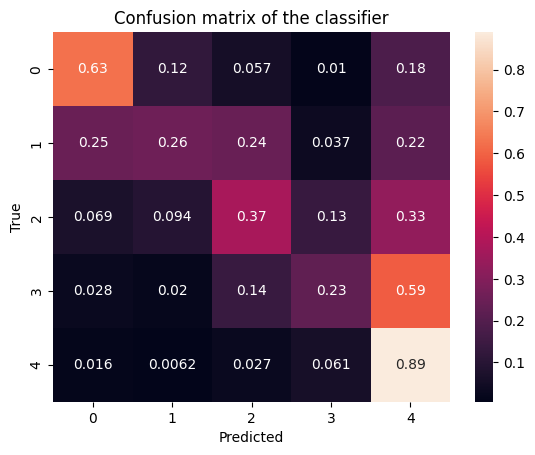

In [46]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [47]:
# Create the submission fdt_
X_submission['Score'] = sgd_model.predict(X_submission_combined)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/content/drive/My Drive/Midterm/submission.csv", index=False)